In [1]:
#to access kaggle datasets
!pip install kaggle
#Math operations
!pip install numpy==1.15.0
#Machine learning
!pip install catboost

In [0]:
#data preprocessing
import pandas as pd
#math operations
import numpy as np
#machine learning
from catboost import CatBoostRegressor, Pool
#data scaling
from sklearn.preprocessing import StandardScaler
#hyperparameter optimization
from sklearn.model_selection import GridSearchCV
#support vector machine model
from sklearn.svm import NuSVR, SVR
#kernel ridge model
from sklearn.kernel_ridge import KernelRidge
#data visualization
import matplotlib.pyplot as plt

In [3]:
# Colab's file access feature
from google.colab import files

#retrieve uploaded file
uploaded = files.upload()

#print results
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [4]:
#list competitions
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2499            True  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge       9896           False  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       4092           False  
imagenet-object-localization-challenge         2029-12-31 07:00:00  Research         Knowledge         35           False  
competitive-data-science-predict-future-sales  2019-12-31 23:59:00  Playground           Kudos       2386           False  
two-sigma-financial-news                       2019-07-15 23:59:00  Featured          $100,000       2927           False  
LANL-Ear

In [5]:
!kaggle competitions download -c LANL-Earthquake-Prediction

  0% 0.00/33.3k [00:00<?, ?B/s]
100% 33.3k/33.3k [00:00<00:00, 13.3MB/s]
 98% 237M/242M [00:01<00:00, 173MB/s]
100% 242M/242M [00:01<00:00, 179MB/s]
100% 2.02G/2.03G [00:40<00:00, 59.8MB/s]
100% 2.03G/2.03G [00:40<00:00, 53.6MB/s]


In [8]:
#list the files
!ls -lrt

total 11704036
---------- 1 root root 9555558244 Jan 10 01:12 train.csv
drwxr-xr-x 1 root root       4096 Feb 15 17:21 sample_data
-rw-r--r-- 1 root root      34135 Feb 24 03:53 sample_submission.csv
-rw-r--r-- 1 root root  253730367 Feb 24 03:53 test.zip
-rw-r--r-- 1 root root 2175592057 Feb 24 03:54 train.csv.zip


In [7]:
#unzip training data for usage, will take about 5 minutes (its big)
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [9]:
!ls -lh

total 12G
drwxr-xr-x 1 root root 4.0K Feb 15 17:21 sample_data
-rw-r--r-- 1 root root  34K Feb 24 03:53 sample_submission.csv
-rw-r--r-- 1 root root 242M Feb 24 03:53 test.zip
---------- 1 root root 8.9G Jan 10 01:12 train.csv
-rw-r--r-- 1 root root 2.1G Feb 24 03:54 train.csv.zip


In [0]:
#Extract training data into a dataframe for further manipulation
train = pd.read_csv('train.csv', nrows=6000000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

In [74]:
#print first 10 entries
train.head(10)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691
7,7,1.4691
8,-5,1.4691
9,3,1.4691


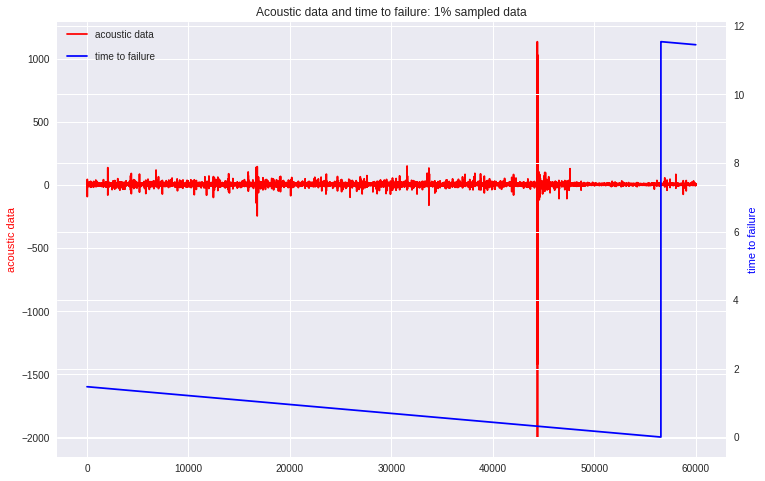

In [75]:
#visualize 1% of samples data, first 100 datapoints
train_ad_sample_df = train['acoustic_data'].values[::100]
train_ttf_sample_df = train['time_to_failure'].values[::100]

#function for plotting based on both features
def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df


In [0]:
# Step 4 - Feature Engineering and signifiance of these statistical features

#lets create a function to generate some statistical features based on the training data
def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(np.quantile(X,0.01))
    strain.append(np.quantile(X,0.05))
    strain.append(np.quantile(X,0.95))
    strain.append(np.quantile(X,0.99))
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())   
    return pd.Series(strain)

In [0]:
train = pd.read_csv('train.csv', iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})


In [0]:
X_train = pd.DataFrame()
y_train = pd.Series()

number_of_chunks = 0
for df in train:
    number_of_chunks += 1
    ch = gen_features(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index=True)    
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))

In [79]:
#information about parameters
print(number_of_chunks)
print(X_train.shape)
print(y_train.shape)
print(X_train.columns)
X_train.head(1)

4195
(4195, 13)
(4195,)
Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64')


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,4.884113,5.101106,-98.0,104.0,33.662481,-0.024061,-8.0,-2.0,11.0,18.0,104.0,5.576567,4.333325


In [80]:
# define meaningful column names for the dataframe and make the change
column_names = ['mean', 'std', 'min', 'max', 'kurtosis', 'skew', 'quntile_01', 
                'quntile_05', 'quntile_95', 'quntile_99', 'abs_max', 'abs_mean', 'abs_std']
X_train.columns = column_names
print(X_train.shape)
print(X_train.columns)
X_train.head(1)

(4195, 13)
Index(['mean', 'std', 'min', 'max', 'kurtosis', 'skew', 'quntile_01',
       'quntile_05', 'quntile_95', 'quntile_99', 'abs_max', 'abs_mean',
       'abs_std'],
      dtype='object')


,mean,std,min,max,kurtosis,skew,quntile_01,quntile_05,quntile_95,quntile_99,abs_max,abs_mean,abs_std
0,4.884113,5.101106,-98.0,104.0,33.662481,-0.024061,-8.0,-2.0,11.0,18.0,104.0,5.576567,4.333325


In [0]:
#save the processed features as separate file
from google.colab import files
processed_dataset_features = X_train.to_csv("processed_dataset_features.csv", index=False)
files.download('processed_dataset_features.csv')

In [0]:
#save the labels too into a separate file
y_train_df = pd.DataFrame({'time_to_failure':y_train})
processed_dataset_features = y_train_df.to_csv('processed_dataset_labels.csv', index=False)
files.download('processed_dataset_labels.csv')

In [83]:
X_train.describe()

,mean,std,min,max,kurtosis,skew,quntile_01,quntile_05,quntile_95,quntile_99,abs_max,abs_mean,abs_std
count,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000
mean,4.519475,6.547788,-149.190942,163.522288,68.297997,0.125830,-11.224603,-2.184779,11.231716,20.321890,170.046246,5.547367,5.750165
std,0.256049,8.503939,265.087984,272.930331,70.532565,0.477901,14.106852,2.346558,2.358067,14.225526,296.887015,1.517038,8.339211
min,3.596313,2.802720,-5515.000000,23.000000,0.648602,-4.091826,-336.000000,-39.000000,9.000000,11.000000,23.000000,4.147707,2.589085
25%,4.349497,4.478637,-154.000000,92.000000,28.090227,-0.040779,-14.000000,-3.000000,10.000000,15.000000,94.000000,5.061843,3.862810
50%,4.522147,5.618798,-111.000000,123.000000,45.816625,0.085620,-10.000000,-2.000000,11.000000,19.000000,127.000000,5.380853,4.781513
75%,4.693350,6.880904,-79.000000,170.000000,78.664202,0.253930,-6.000000,-1.000000,12.000000,23.000000,175.000000,5.748553,5.887947
max,5.391993,153.703569,-15.000000,5444.000000,631.158927,4.219429,-2.000000,0.000000,50.000000,337.000000,5515.000000,32.762073,150.432368


In [87]:
#Model #1 - Catboost

train_pool = Pool(X_train, y_train)
m = CatBoostRegressor(iterations=10000, loss_function='MAE', boosting_type='Ordered')
m.fit(X_train, y_train, silent=True)
m.best_score_

{'learn': {'MAE': 1.7804224713035586}}

In [0]:
#Model #2 - Support Vector Machine w/ RBF + Grid Search

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR, SVR


scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

parameters = [{'gamma': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
               'C': [0.1, 0.2, 0.25, 0.5, 1, 1.5, 2]}]
               #'nu': [0.75, 0.8, 0.85, 0.9, 0.95, 0.97]}]

reg1 = GridSearchCV(SVR(kernel='rbf', tol=0.01), parameters, cv=5, scoring='neg_mean_absolute_error')
reg1.fit(X_train_scaled, y_train.values.flatten())
y_pred1 = reg1.predict(X_train_scaled)

print("Best CV score: {:.4f}".format(reg1.best_score_))
print(reg1.best_params_)

Best CV score: -2.1722
{'C': 2, 'gamma': 0.02}


In [0]:
#process test data and make predictions
!mkdir -p test
!unzip test.zip -d test

In [0]:
!ls -lh test

In [0]:
!ls -lh

In [0]:
import os
#os.chdir("test")
os.listdir()

In [0]:
X_test = pd.DataFrame()

In [0]:
indexes = []
for file in os.listdir():
    indexes.append(file)
    df = pd.read_csv(file)
    ch = gen_features(df['acoustic_data'])
    X_test = X_test.append(ch, ignore_index=True)    

In [104]:
X_test.columns = column_names
print(X_test.shape)
print(X_test.columns)
X_test.head(1)

(2624, 13)
Index(['mean', 'std', 'min', 'max', 'kurtosis', 'skew', 'quntile_01',
       'quntile_05', 'quntile_95', 'quntile_99', 'abs_max', 'abs_mean',
       'abs_std'],
      dtype='object')


,mean,std,min,max,kurtosis,skew,quntile_01,quntile_05,quntile_95,quntile_99,abs_max,abs_mean,abs_std
0,4.016047,3.525807,-56.0,54.0,13.939222,-0.053785,-4.0,-1.0,9.0,13.0,56.0,4.406153,3.024191


In [0]:
pred = m.predict(X_test)

In [108]:
print(type(pred))
print(len(pred))
print(pred.shape)

<class 'numpy.ndarray'>
2624
(2624,)


In [0]:
submission_df = pd.read_csv('../sample_submission.csv')

In [110]:
submission_df.columns

Index(['seg_id', 'time_to_failure'], dtype='object')

In [111]:
len(submission_df['time_to_failure'])

2624

In [0]:
submission_df['time_to_failure'] = pred

In [113]:
submission_df.head(5)

,seg_id,time_to_failure
0,seg_00030f,8.993046
1,seg_0012b5,4.430358
2,seg_00184e,6.953948
3,seg_003339,8.189503
4,seg_0042cc,6.419600


In [0]:
submission_df.to_csv('../sample_submission1.csv', index=False)

In [0]:
files.download('../sample_submission1.csv')

In [0]:
##It was a regression model. Used catboost library with sci-kit learn for making the predictions. Pre-processed the data as one set of summary statistics for each of the 15000 observations for whole dataset.

In [0]:
processed_dataset_features_test = X_test.to_csv("processed_dataset_features_test.csv", index=False)
files.download('processed_dataset_features_test.csv')